In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [2]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import pickle
import pandas as pd
import os
import random
import seaborn as sns

from tqdm import tqdm
from src.data.loaders import get_loader
from joblib import Parallel, delayed
from functools import partial
%load_ext autoreload
%autoreload 2

2024-09-06 12:22:01.201453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 12:22:01.201522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 12:22:01.201555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 12:22:01.210692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## MACHO stats

In [3]:
def get_stat(path, on='mag', window=100):
    observations = pd.read_parquet(path)
    observations = observations[(observations['errmag']>0) & (observations['errmag']<1)]
    
    if on == 'mjd':
        observations = observations.groupby('newID').diff().dropna()
        
    observations = observations.sort_values(on)
    observations = observations[on].rolling(window=window, step=window).mean()
    return observations.dropna().tolist()

def calculate_stat(root, on='mag', window=1000, njobs=4):
    lc_paths = os.listdir(root)
    preloaded = partial(get_stat, on=on, window=window)
    var = Parallel(n_jobs=njobs, backend='threading')
    results = var(delayed(preloaded)(os.path.join(root, p)) for p in lc_paths )
    flattened = [item for sublist in results for item in sublist]
    return flattened

In [4]:
%%time
root = './data/raw_parquet/macho/light_curves/'
macho_mjd = calculate_stat(root, on='mjd', njobs=32)
macho_mjd = np.array(macho_mjd)[np.array(macho_mjd)>0]

macho_mag = calculate_stat(root, on='mag', njobs=32)

CPU times: user 23min 16s, sys: 6min 40s, total: 29min 57s
Wall time: 1min 42s


In [5]:
%%time
root = './data/raw_parquet/alcock/light_curves/'
other_mjd = calculate_stat(root, on='mjd', njobs=32)
other_mjd = np.array(other_mjd)[np.array(other_mjd)>0]

other_mag = calculate_stat(root, on='mag', njobs=32)

CPU times: user 6.51 s, sys: 2.02 s, total: 8.53 s
Wall time: 6.25 s


In [16]:
with open('./data/shared/records/bigmacho/bigmacho_magnitudes.pickle', 'rb') as handle:
    bighmacho_mag = pickle.load(handle)

In [17]:
indices = np.arange(len(bighmacho_mag))
np.random.shuffle(indices)
indices = indices[:len(macho_mag)*2]
bighmacho_mag = np.array(bighmacho_mag)[indices]
len(bighmacho_mag)

2390180

In [18]:
NAMEOTHER = 'Alcock'

2024-09-02 13:54:03,971 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-02 13:54:05,226 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
<timed exec>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


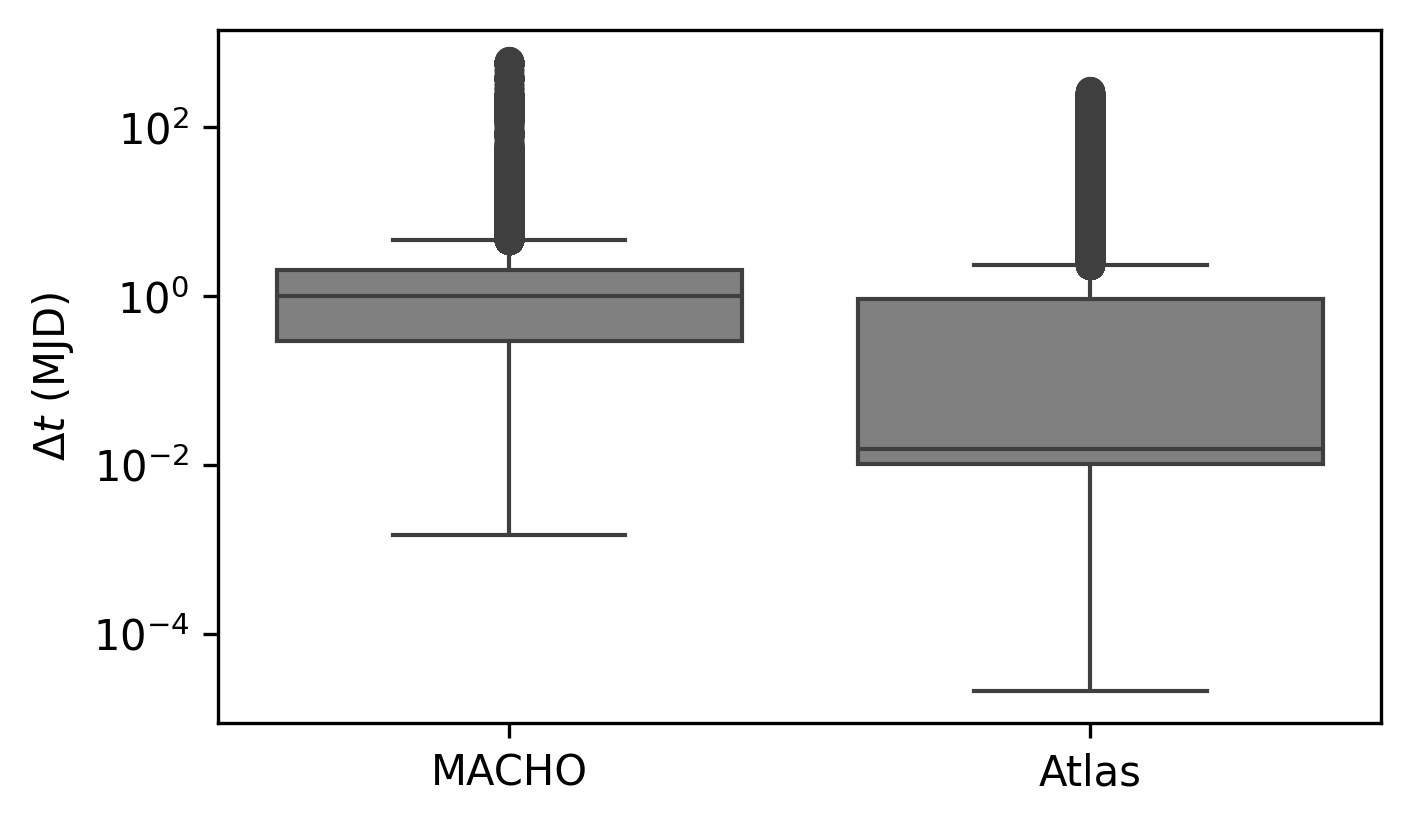

CPU times: user 7.03 s, sys: 614 ms, total: 7.64 s
Wall time: 7.12 s


In [18]:
%%time
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5,3))
sns.boxplot(data=[macho_mjd, other_mjd], ax=ax, color='gray')
ax.set_yscale('log')
ax.set_ylabel(r'$\Delta t$ (MJD)')
ax.set_xticklabels(['MACHO', NAMEOTHER])

fig.savefig('./presentation/figures/macho_vs_{}_mjd.pdf'.format(NAMEOTHER), 
            format='pdf', 
            bbox_inches='tight')
plt.show()

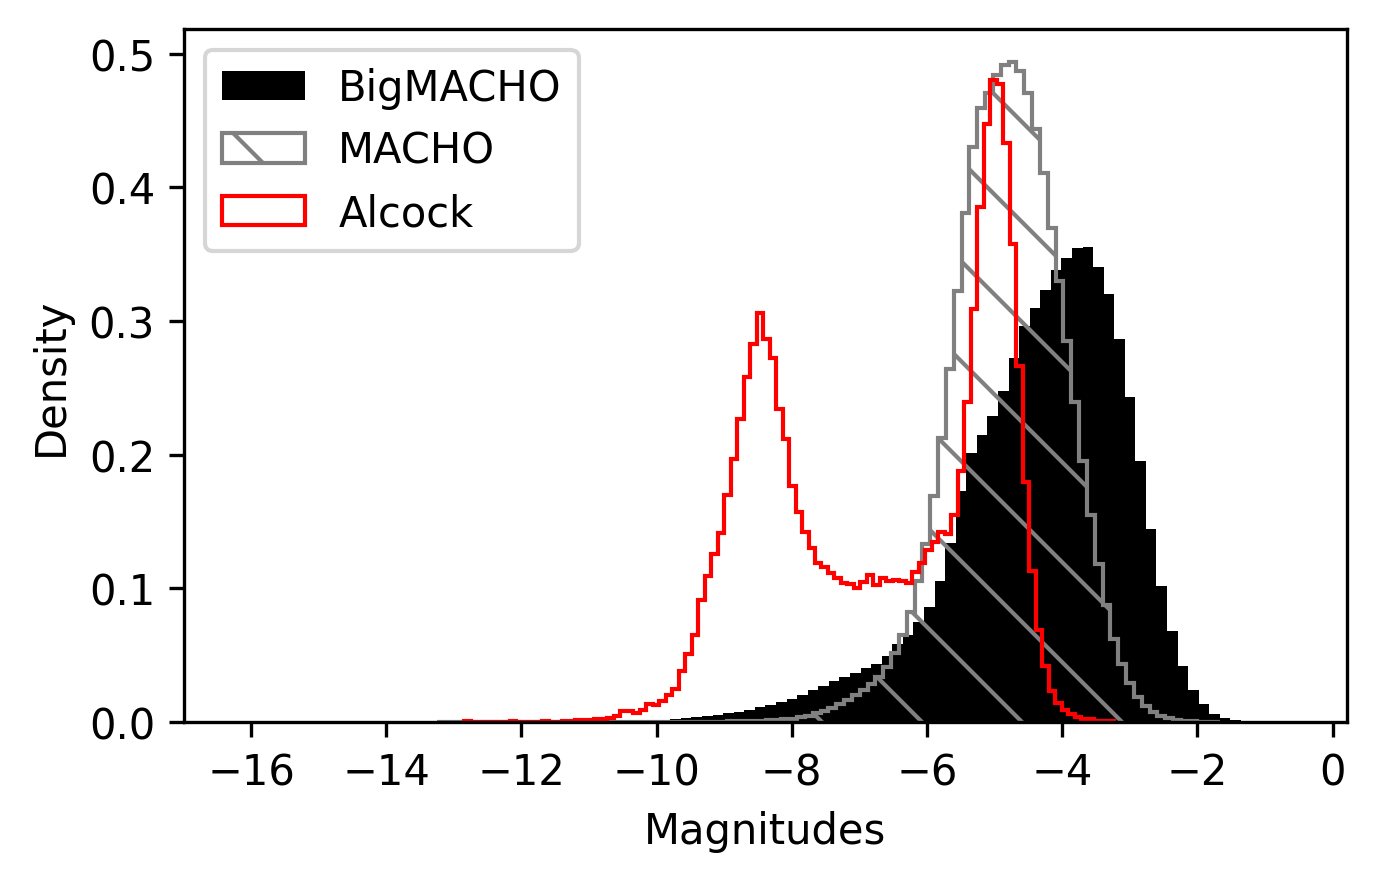

CPU times: user 3.23 s, sys: 594 ms, total: 3.83 s
Wall time: 3.32 s


In [38]:
%%time
plt.figure(figsize=(5, 3), dpi=300)
h2 = plt.hist(bighmacho_mag, bins=100,  density=True, label='BigMACHO', facecolor='k')
h1 = plt.hist(macho_mag, bins=100,  density=True, label='MACHO', facecolor='gray', histtype='step', 
              edgecolor='gray', hatch='\\')
h3 = plt.hist(other_mag, bins=100,  density=True, label=NAMEOTHER, histtype='step', color='r')
plt.legend()
plt.xlabel('Magnitudes')
plt.ylabel('Density')
# plt.yscale('log')
plt.savefig('./presentation/figures/macho_big_vs_{}_mag.pdf'.format(NAMEOTHER), format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
scan2 = pl.scan_parquet('./data/raw_parquet/alcock/light_curves/*.parquet')

/tmp/ipykernel_3885663/3473373314.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(xticks, means, stds, fmt='.k', lw=4, color='black')


<ErrorbarContainer object of 3 artists>

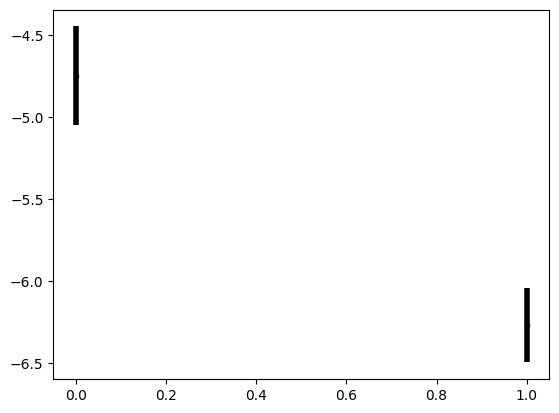

In [51]:
labels = ['MACHO', 'Alcock']
xticks = np.arange(len(labels))

means = np.array([features['mean'].mean(), features2['mean'].mean()])
stds = np.array([features['std'].mean(), features2['std'].mean()])
mins = np.array([features['min'].min(), features2['min'].min()])
maxes = np.array([features['max'].max(), features2['max'].max()])


# plt.errorbar(xticks, means, [means - mins, maxes - means], fmt='.k', ecolor='gray', lw=0.5)
plt.errorbar(xticks, means, stds, fmt='.k', lw=4, color='black')
